<a href="https://colab.research.google.com/github/duynguyen02/tls_ml_loan_prediction_1/blob/main/loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lợi nhuận của ngân hàng được tạo ra phần lớn thông qua các khoản vay. Mặc dù có rất nhiều người đăng ký cho các khoản vay, nhưng khó để chọn người có khả năng chi trả các khoản đã vay. Với việc thực hiện xác định bằng thủ công sẽ gặp rất nhiều vấn đề bất cập và sai sót xảy ra. Vì vậy việc ứng dụng Machine Learning trong việc dự đoán khả năng chi trả các khoản vay là một việc làm cần thiết để phân tích thông kê và đưa ra các quyết định để xác nhận các khoản cho phép vay phù hợp.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy import stats

import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier

from google.colab import files

In [ ]:
# uploaded = files.upload()

In [ ]:
loan_train = pd.read_csv('train_csv.csv')
loan_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
loan_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
loan_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [ ]:
loan_train.shape

(614, 13)

In [ ]:
loan_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [ ]:
loan_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### Xử lý dữ liệu bị thiếu

In [ ]:
# lắp giá trị xuất hiện nhiều nhất vào các giá trị null
loan_train['Gender'].fillna(loan_train['Gender'].dropna().mode().values[0], inplace=True)
loan_train['Married'].fillna(loan_train['Married'].dropna().mode().values[0], inplace=True)
loan_train['Dependents'].fillna(loan_train['Dependents'].dropna().mode().values[0], inplace=True)
loan_train['Self_Employed'].fillna(loan_train['Self_Employed'].dropna().mode().values[0], inplace=True)
loan_train['Loan_Amount_Term'].fillna(loan_train['Loan_Amount_Term'].dropna().mode().values[0], inplace=True)
loan_train['Credit_History'].fillna(loan_train['Credit_History'].dropna().mode().values[0], inplace=True)

# lắp giá trị trung bình của toàn tập dữ liệu
loan_train['LoanAmount'].fillna(loan_train['LoanAmount'].dropna().mean(), inplace=True)



### Data Visualization

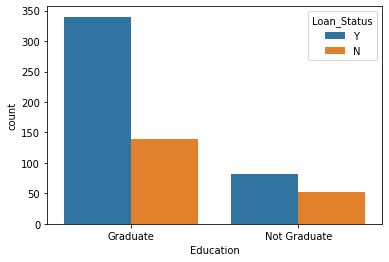

In [ ]:
sns.countplot(x='Education', hue='Loan_Status', data=loan_train)

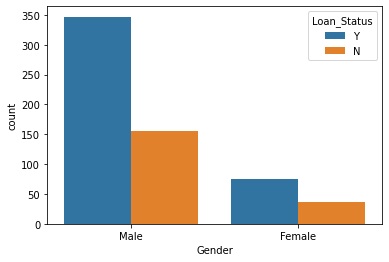

In [ ]:
sns.countplot(x='Gender', hue='Loan_Status', data=loan_train)

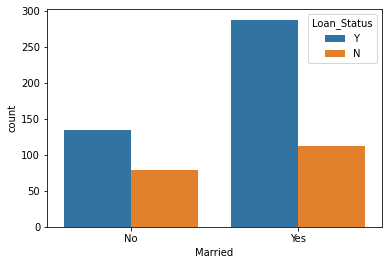

In [ ]:
sns.countplot(x='Married', hue='Loan_Status', data=loan_train)

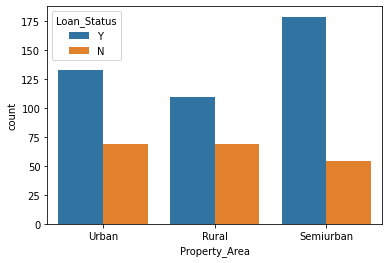

In [ ]:
sns.countplot(x='Property_Area', hue='Loan_Status', data=loan_train)

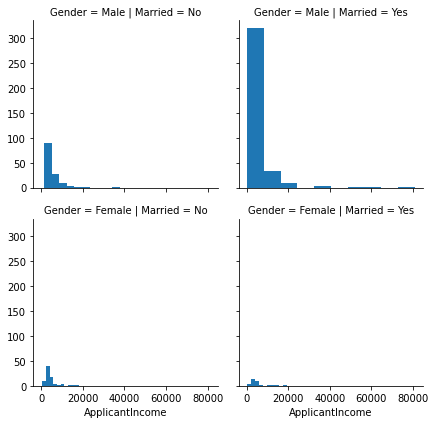

In [ ]:
# mô tả phân bổ thu nhập thông qua giới tính và tình trạng hôn nhân
grid = sns.FacetGrid(loan_train, row='Gender', col='Married')
grid.map(plt.hist, 'ApplicantIncome')
grid.add_legend()

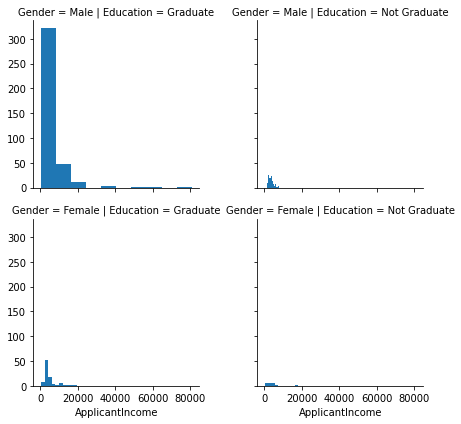

In [ ]:
# mô tả phân bổ thu nhập thông qua giới tính và giáo dục
grid = sns.FacetGrid(loan_train, row='Gender', col='Education')
grid.map(plt.hist, 'ApplicantIncome')
grid.add_legend()

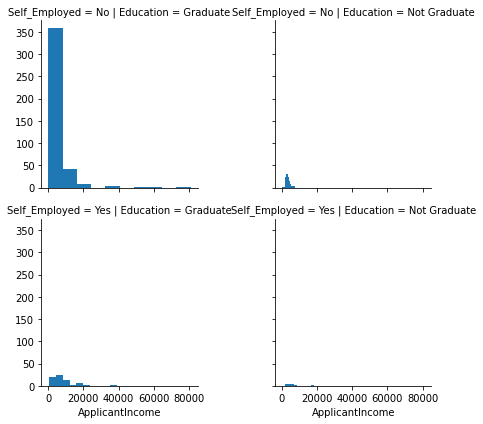

In [ ]:
# mô tả phân bổ thu nhập thông qua giới tính và tự kinh doanh
grid = sns.FacetGrid(loan_train, row='Self_Employed', col='Education')
grid.map(plt.hist, 'ApplicantIncome')
grid.add_legend()

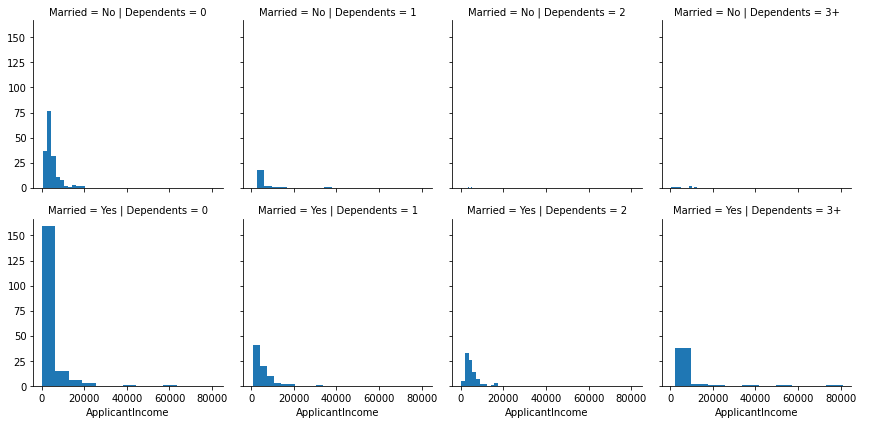

In [ ]:
grid = sns.FacetGrid(loan_train, row='Married', col='Dependents')
grid.map(plt.hist, 'ApplicantIncome')
grid.add_legend()

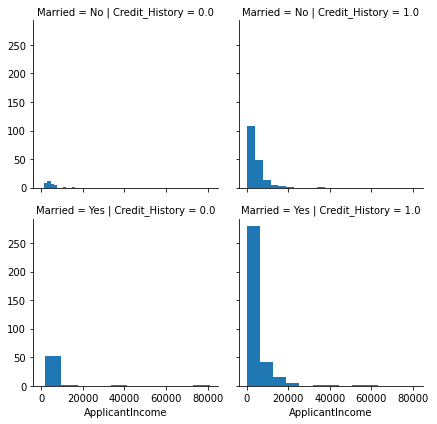

In [ ]:
# mô tả phân bổ thu nhập thông qua tình trạng hôn nhân và lịch sử tín dụng
grid = sns.FacetGrid(loan_train, row='Married', col='Credit_History')
grid.map(plt.hist, 'ApplicantIncome')
grid.add_legend()

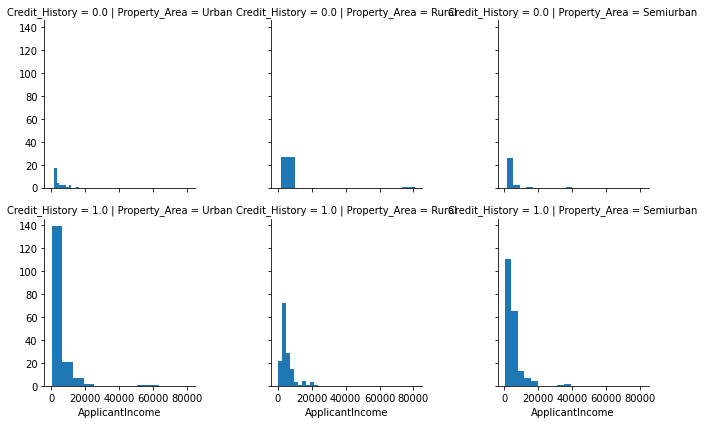

In [ ]:
grid = sns.FacetGrid(loan_train, row='Credit_History', col='Property_Area')
grid.map(plt.hist, 'ApplicantIncome')
grid.add_legend()

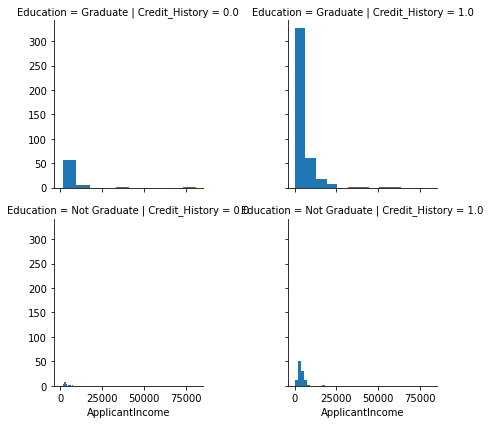

In [ ]:
grid = sns.FacetGrid(loan_train, row='Education', col='Credit_History')
grid.map(plt.hist, 'ApplicantIncome')
grid.add_legend()


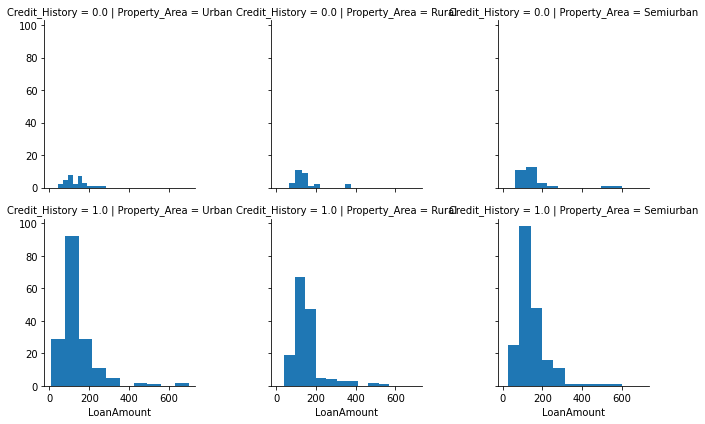

In [ ]:
grid = sns.FacetGrid(loan_train, row='Credit_History', col='Property_Area')
grid.map(plt.hist, 'LoanAmount')
grid.add_legend()

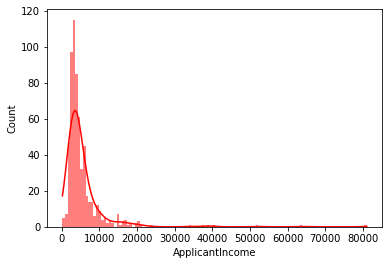

<Figure size 432x288 with 0 Axes>

In [ ]:
#histogram and normal probability plot
sns.histplot(loan_train['ApplicantIncome'], color='red', kde=True, linewidth=0)
fig = plt.figure()

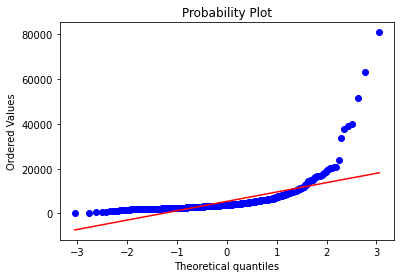

In [ ]:
res = stats.probplot(loan_train['ApplicantIncome'], plot=plt)

### Coorelation Matrix

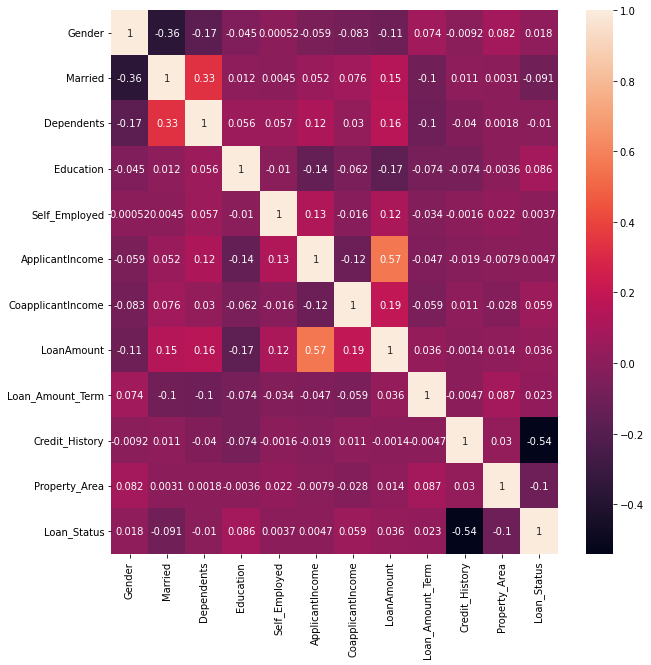

In [ ]:
corr = loan_train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot = True)

###Tính giá trị bình thu nhập theo các thuộc tính

In [ ]:
loan_train[['Gender', 'ApplicantIncome']].groupby(['Gender'],
                                               as_index = False).mean().sort_values(by = 'Gender', ascending = False)

,Gender,ApplicantIncome
1,Male,5573.017928
0,Female,4643.473214


In [ ]:
loan_train[['Married', 'ApplicantIncome']].groupby(['Married'],
                                               as_index = False).mean().sort_values(by = 'Married', ascending = False)

,Married,ApplicantIncome
1,Yes,5633.496259
0,No,4970.384977


In [ ]:
loan_train[['Education', 'ApplicantIncome']].groupby(['Education'],
                                               as_index = False).mean().sort_values(by = 'Education', ascending = False)

,Education,ApplicantIncome
1,Not Graduate,3777.283582
0,Graduate,5857.433333


In [ ]:
loan_train[['Self_Employed', 'ApplicantIncome']].groupby(['Self_Employed'],
                                               as_index = False).mean().sort_values(by = 'Self_Employed', ascending = False)

,Self_Employed,ApplicantIncome
1,Yes,7380.817073
0,No,5098.678571


In [ ]:
loan_train[['Gender', 'Married', 'ApplicantIncome']].groupby(['Gender', 'Married'],
                                               as_index = False).mean().sort_values(by = 'Gender', 
                                                                                          ascending = False)

,Gender,Married,ApplicantIncome
2,Male,No,5251.045113
3,Male,Yes,5689.067751
0,Female,No,4503.787500
1,Female,Yes,4992.687500


In [ ]:
def print_data_type():
    print(set(loan_train['Gender'].values.tolist()))
    print(set(loan_train['Dependents'].values.tolist()))
    print(set(loan_train['Married'].values.tolist()))
    print(set(loan_train['Education'].values.tolist()))
    print(set(loan_train['Self_Employed'].values.tolist()))
    print(set(loan_train['Loan_Status'].values.tolist()))
    print(set(loan_train['Property_Area'].values.tolist()))
    print(set(loan_train['Loan_Status'].values.tolist()))

In [ ]:
print_data_type()


{'Female', 'Male'}
{'0', '3+', '1', '2'}
{'No', 'Yes'}
{'Not Graduate', 'Graduate'}
{'No', 'Yes'}
{'N', 'Y'}
{'Semiurban', 'Rural', 'Urban'}
{'N', 'Y'}


### Chuyển kiểu dữ liệu về số

In [ ]:
col_to_scale = ['Gender', 'Dependents', 'Married', 'Education', 'Self_Employed', 'Loan_Status', 'Property_Area', 'Loan_Status']

for col_name in col_to_scale:
    loan_train[col_name] = pd.factorize(loan_train[col_name])[0]  


In [ ]:
print_data_type()

{0, 1}
{0, 1, 2, 3}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1, 2}
{0, 1}


In [ ]:

# %matplotlib inline
# loan_train.boxplot(column='ApplicantIncome')

In [ ]:
# loan_train['ApplicantIncome'].hist(bins=20)

In [ ]:
y = loan_train['Loan_Status']
x = loan_train.drop(['Loan_Status', 'Loan_ID'], axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size= 0.2, random_state = 42)

In [ ]:
from sklearn import preprocessing

X_train = preprocessing.scale(X_train)
Y_train = preprocessing.scale(Y_train)
X_test = preprocessing.scale(X_test)
Y_test = preprocessing.scale(Y_test)

lab = preprocessing.LabelEncoder()

num_rows, num_cols = X_train.shape
for i in range(0,num_rows):
    X_train[i] = lab.fit_transform(X_train[i])
num_rows, num_cols = X_test.shape
for i in range(0,num_rows):
  X_test[i] = lab.fit_transform(X_test[i])

Y_train = lab.fit_transform(Y_train)
Y_test = lab.fit_transform(Y_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC
from scipy.stats import norm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
kfold = KFold(n_splits=10)
def classify(model):
  model.fit(X_train, Y_train)
  print(model)
  print(f"Độ chính xác: {model.score(X_test, Y_test)}")
  print(f"Cross validation: {np.mean(cross_val_score(model, x, y, cv=kfold))}")
  # x_train_pred = model.predict(X_train)
  # trainning_data_accuray = accuracy_score(x_train_pred, Y_train)
  # print(f"Độ chính xác test của tập train: {trainning_data_accuray}")
  # x_test_pred = model.predict(X_test)
  # test_data_accuray = accuracy_score(x_test_pred, Y_test)
  # print(f"Độ chính xác test của tập test: {test_data_accuray}")
  print("-"*50)

In [ ]:
models = [
    LogisticRegression(max_iter=3000),
    DecisionTreeClassifier(max_depth=4),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier(),
    KNeighborsClassifier(),
    SVC()
]


for model in models:
  classify(model)

LogisticRegression(max_iter=3000)
Độ chính xác train: 0.7886178861788617
Cross validation: 0.8080116340560549
--------------------------------------------------
DecisionTreeClassifier(max_depth=4)
Độ chính xác train: 0.7723577235772358
Cross validation: 0.7966155473294554
--------------------------------------------------
RandomForestClassifier()
Độ chính xác train: 0.7723577235772358
Cross validation: 0.790058170280275
--------------------------------------------------
GradientBoostingClassifier()
Độ chính xác train: 0.7154471544715447
Cross validation: 0.773823373876256
--------------------------------------------------
ExtraTreesClassifier()
Độ chính xác train: 0.7723577235772358
Cross validation: 0.7671602326811211
--------------------------------------------------
KNeighborsClassifier()
Độ chính xác train: 0.7560975609756098
Cross validation: 0.6189053410893707
--------------------------------------------------
SVC()
Độ chính xác train: 0.7886178861788617
Cross validation: 0.68569

In [ ]:
# dec_tree_clf = DecisionTreeClassifier(max_depth=4)
# dec_tree_clf = dec_tree_clf.fit(X_train, Y_train)
# plot_tree(dec_tree_clf, filled=True)
# dec_tree_clf.score(X_test, Y_test)


In [ ]:
# svm_clf = SVC(kernel='linear')
# svm_clf.fit(X_train, Y_train)
# x_train_pred = svm_clf.predict(X_train)
# trainning_data_accuray = accuracy_score(x_train_pred, Y_train)
# print(f"Độ chính xác của tập train: {trainning_data_accuray}")
# x_test_pred = svm_clf.predict(X_test)
# test_data_accuray = accuracy_score(x_test_pred, Y_test)
# print(f"Độ chính xác của tập test: {test_data_accuray}")